In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df_test = pd.read_csv('test.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


<h2>Visualization</h2>

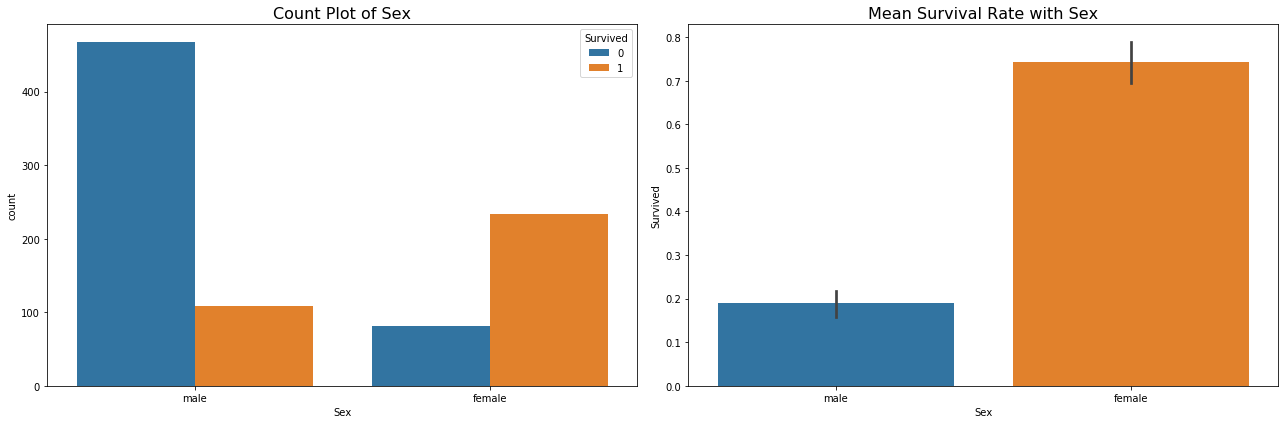

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'Sex', hue='Survived', data = df, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize = 16)
sns.barplot(x='Sex', y='Survived', data = df, ax=ax[1])
ax[1].set_title('Mean Survival Rate with Sex',fontsize = 16)
plt.tight_layout()
plt.show()

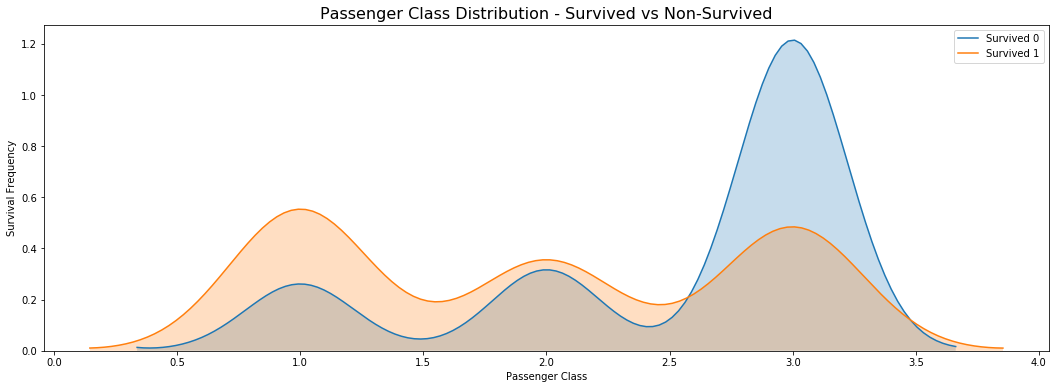

In [7]:
fig, ax = plt.subplots(figsize = (18,6))
ax = sns.kdeplot(df[df['Survived'] == 0]['Pclass'], label = 'Survived 0', shade = True)
ax = sns.kdeplot(df[df['Survived'] == 1]['Pclass'], label = 'Survived 1', shade = True)
ax.set_title('Passenger Class Distribution - Survived vs Non-Survived', fontsize = 16)
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Survival Frequency')
plt.show()


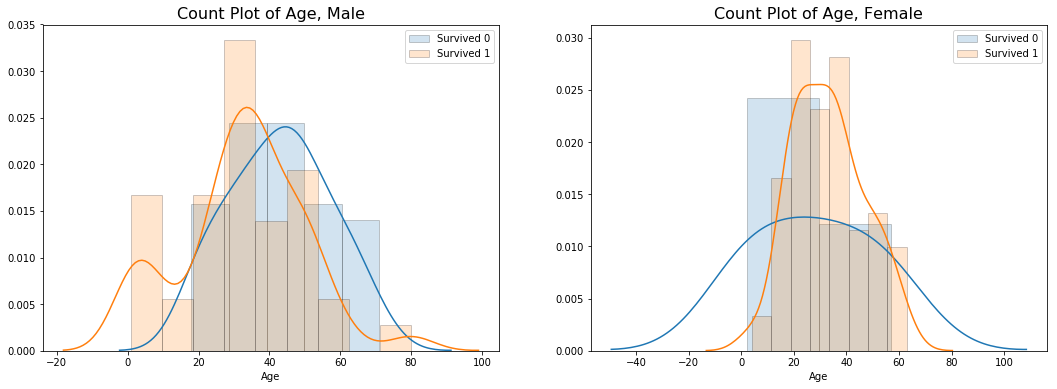

In [8]:
#grouped_Age = df[['Age', 'Survived']].groupby('Age').mean().reset_index()
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
df_male = df[df['Sex'] == 'male'].dropna()
df_female = df[df['Sex'] == 'female'].dropna()
sns.distplot(df_male[df_male['Survived'] == 0]['Age'], label = 'Survived 0',
            ax=ax[0], hist_kws=hist_kws)
sns.distplot(df_male[df_male['Survived'] == 1]['Age'], label = 'Survived 1',
            ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age, Male', fontsize = 16)
ax[0].legend()
sns.distplot(df_female[df_female['Survived'] == 0]['Age'], label = 'Survived 0',
            ax=ax[1], hist_kws=hist_kws)
sns.distplot(df_female[df_female['Survived'] == 1]['Age'], label = 'Survived 1',
            ax=ax[1], hist_kws=hist_kws)
ax[1].set_title('Count Plot of Age, Female', fontsize = 16)
ax[1].legend()

plt.show()

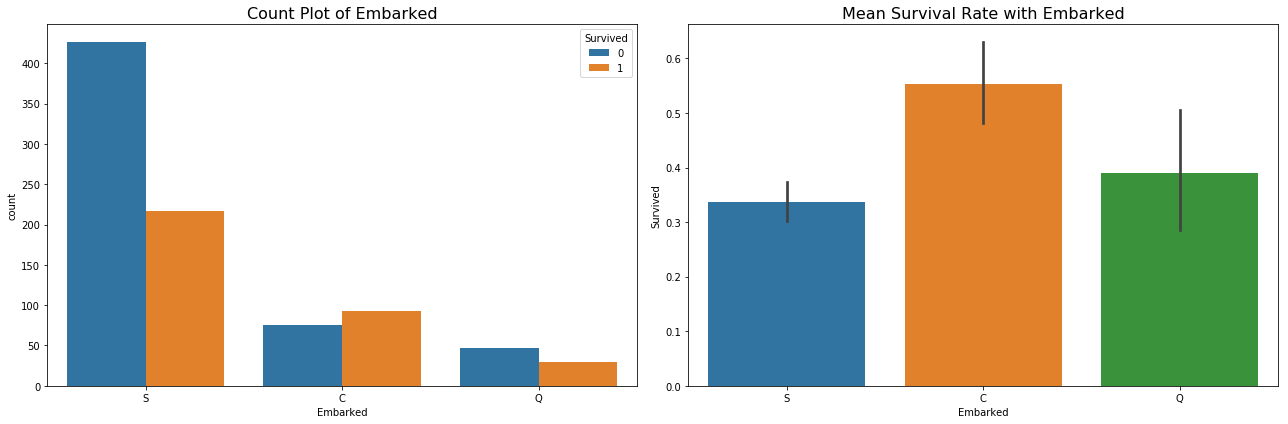

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'Embarked', hue='Survived', data = df, ax=ax[0])
ax[0].set_title('Count Plot of Embarked', fontsize = 16)
sns.barplot(x='Embarked', y='Survived', data = df, ax=ax[1])
ax[1].set_title('Mean Survival Rate with Embarked',fontsize = 16)
plt.tight_layout()
plt.show()

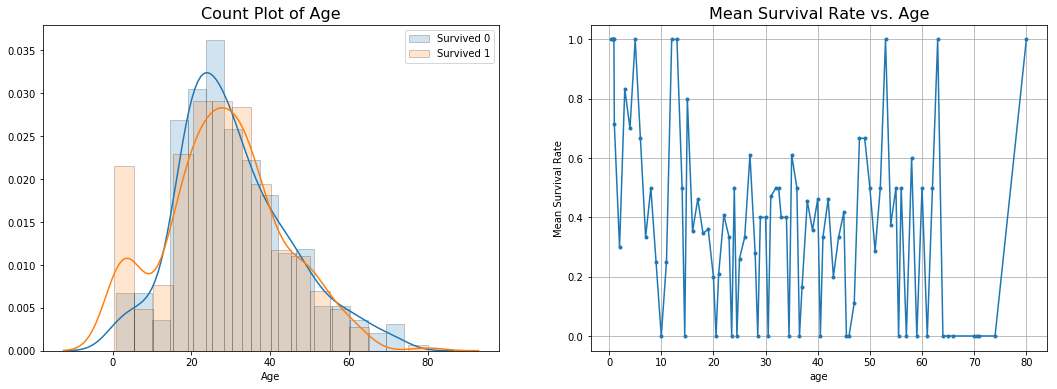

In [10]:
grouped_Age = df[['Age', 'Survived']].groupby('Age').mean().reset_index()
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.distplot(df[df['Survived'] == 0]['Age'].dropna(), label = 'Survived 0',
            ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['Survived'] == 1]['Age'].dropna(), label = 'Survived 1',
            ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize = 16)
ax[0].legend()
ax[1].plot(grouped_Age['Age'], grouped_Age['Survived'], '.-')
ax[1].set_title('Mean Survival Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean Survival Rate')
ax[1].grid(True)
plt.show()

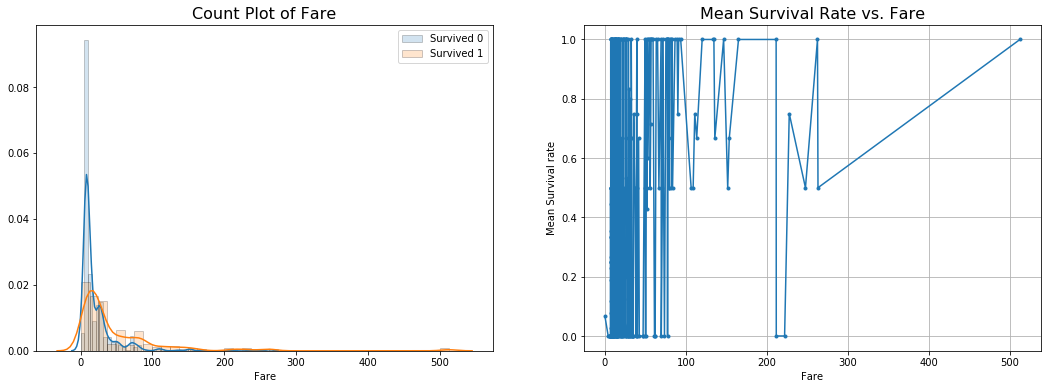

In [11]:
grouped_Fare = df[['Fare', 'Survived']].groupby('Fare').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df[df['Survived'] == 0]['Fare'], 
             label='Survived 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['Survived'] == 1]['Fare'], 
             label='Survived 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Fare', fontsize=16)
ax[0].legend()
ax[1].plot(grouped_Fare['Fare'], grouped_Fare['Survived'], '.-')
ax[1].set_title('Mean Survival Rate vs. Fare', fontsize=16)
ax[1].set_xlabel('Fare')
ax[1].set_ylabel('Mean Survival rate')
ax[1].grid(True)
plt.show()

<h2>Feature Engineering</h2>

<h3>Age</h3>

[Text(0.5, 0, 'PassengerId'),
 Text(1.5, 0, 'Survived'),
 Text(2.5, 0, 'Pclass'),
 Text(3.5, 0, 'Age'),
 Text(4.5, 0, 'SibSp'),
 Text(5.5, 0, 'Parch'),
 Text(6.5, 0, 'Fare')]

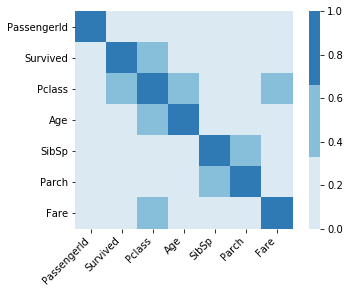

In [12]:
corr = abs(df.corr())
ax = sns.heatmap(
    corr,
    vmin = 0, vmax = 1, center = 0,
    cmap = sns.color_palette("RdBu"),
    square = True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment='right')

In [13]:
corr.sort_values(kind = 'quicksort', ascending = False, by = 'Age')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Age,0.036847,0.077221,0.369226,1.000000,0.308247,0.189119,0.096067
Pclass,0.035144,0.338481,1.000000,0.369226,0.083081,0.018443,0.549500
SibSp,0.057527,0.035322,0.083081,0.308247,1.000000,0.414838,0.159651
Parch,0.001652,0.081629,0.018443,0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,0.549500,0.096067,0.159651,0.216225,1.000000
Survived,0.005007,1.000000,0.338481,0.077221,0.035322,0.081629,0.257307
PassengerId,1.000000,0.005007,0.035144,0.036847,0.057527,0.001652,0.012658


In [14]:
agegroup = pd.DataFrame(df.groupby(['Sex', 'Pclass']).median()['Age']).reset_index()

In [15]:
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

<h3>Embarked</h3>

In [16]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

<h3>Cabin</h3>

In [17]:
df_Cabin = df[~pd.isnull(df['Cabin'])].reset_index()

In [18]:
def get_letter(x):
    import re
    pattern = r'^[a-zA-Z]'
    return re.search(pattern,x).group(0).strip()

In [19]:
Cabin_class = []
for i in range(len(df_Cabin)):
    x = df_Cabin['Cabin'].iloc[i]
    Cabin_class.append(get_letter(x))
    

In [20]:
df_Cabin['Cabin_class'] = Cabin_class

In [21]:
df_Cabin.groupby(['Cabin_class', 'Pclass']).size()

Cabin_class  Pclass
A            1         15
B            1         47
C            1         59
D            1         29
             2          4
E            1         25
             2          4
             3          3
F            2          8
             3          5
G            3          4
T            1          1
dtype: int64

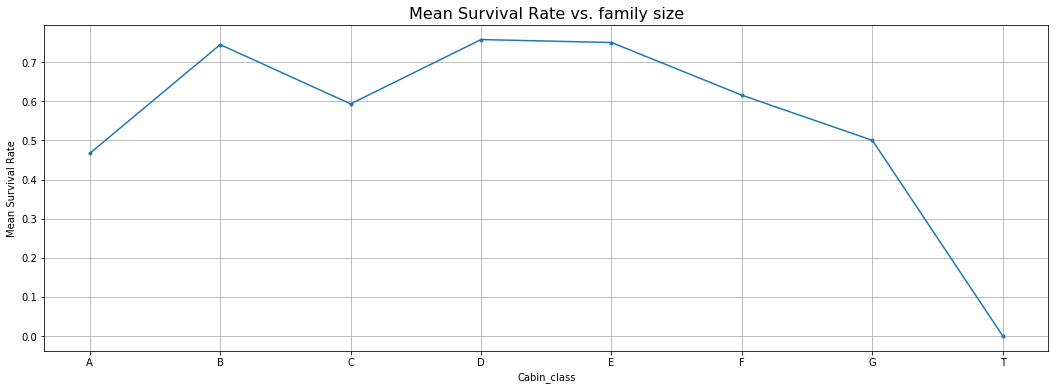

In [22]:
grouped_cabin = df_Cabin[['Cabin_class', 'Survived']].groupby('Cabin_class').mean().reset_index()
fig, ax = plt.subplots(figsize = (18,6))
ax.plot(grouped_cabin['Cabin_class'], grouped_cabin['Survived'], '.-')
ax.set_title('Mean Survival Rate vs. family size', fontsize=16)
ax.set_xlabel('Cabin_class')
ax.set_ylabel('Mean Survival Rate')
ax.grid(True)
plt.show()

In [23]:
df['Cabin'].fillna('M', inplace = True)

In [24]:
Cabin_class = []
for i in range(len(df)):
    x = df['Cabin'].iloc[i]
    Cabin_class.append(get_letter(x))

In [25]:
df['Cabin_class'] = Cabin_class

In [26]:
df['Cabin_class'] = df['Cabin_class'].replace(['A', 'B', 'C'], 'ABC')
df['Cabin_class'] = df['Cabin_class'].replace(['D', 'E'], 'DE')
df['Cabin_class'] = df['Cabin_class'].replace(['F', 'G', 'T'], 'FGT')

In [27]:
df['Cabin_class'].value_counts()

M      687
ABC    121
DE      65
FGT     18
Name: Cabin_class, dtype: int64

<h3>Create new feature: family size</h3>

In [28]:
family = []
for i in range(len(df)):
    family.append(df['SibSp'][i] + df['Parch'][i] + 1)

In [29]:
df['family_size'] = family

In [30]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_class,family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,M,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,ABC,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,M,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,ABC,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,M,1


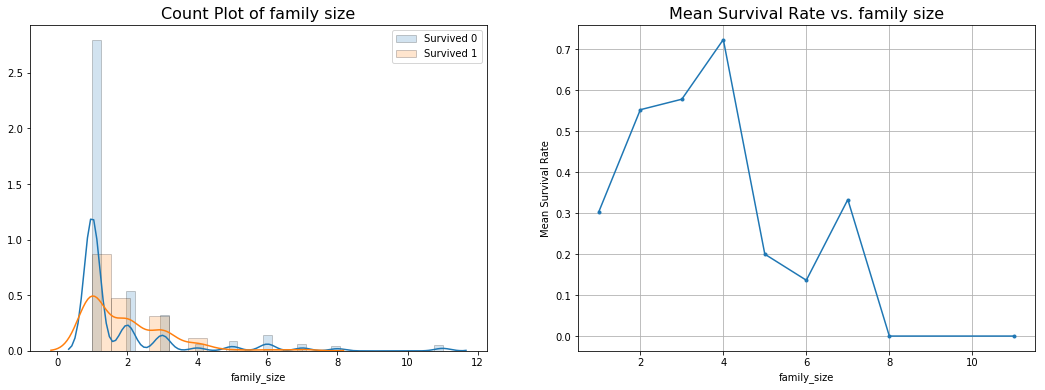

In [31]:
grouped_family = df[['family_size', 'Survived']].groupby('family_size').mean().reset_index()
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.distplot(df[df['Survived'] == 0]['family_size'], label = 'Survived 0',
            ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['Survived'] == 1]['family_size'], label = 'Survived 1',
            ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of family size', fontsize = 16)
ax[0].legend()
ax[1].plot(grouped_family['family_size'], grouped_family['Survived'], '.-')
ax[1].set_title('Mean Survival Rate vs. family size', fontsize=16)
ax[1].set_xlabel('family_size')
ax[1].set_ylabel('Mean Survival Rate')
ax[1].grid(True)
plt.show()

<h3>Create new feature: Title</h3>

In [32]:
title = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [33]:
df['title'] = title

In [34]:
df.groupby('title').size()

title
Capt              1
Col               2
Don               1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           40
Miss            182
Mlle              2
Mme               1
Mr              517
Mrs             125
Ms                1
Rev               6
Sir               1
the Countess      1
dtype: int64

In [35]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Master",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    "Dona" : "Royalty"    
}
df['title'] = df['title'].map(Title_Dictionary)

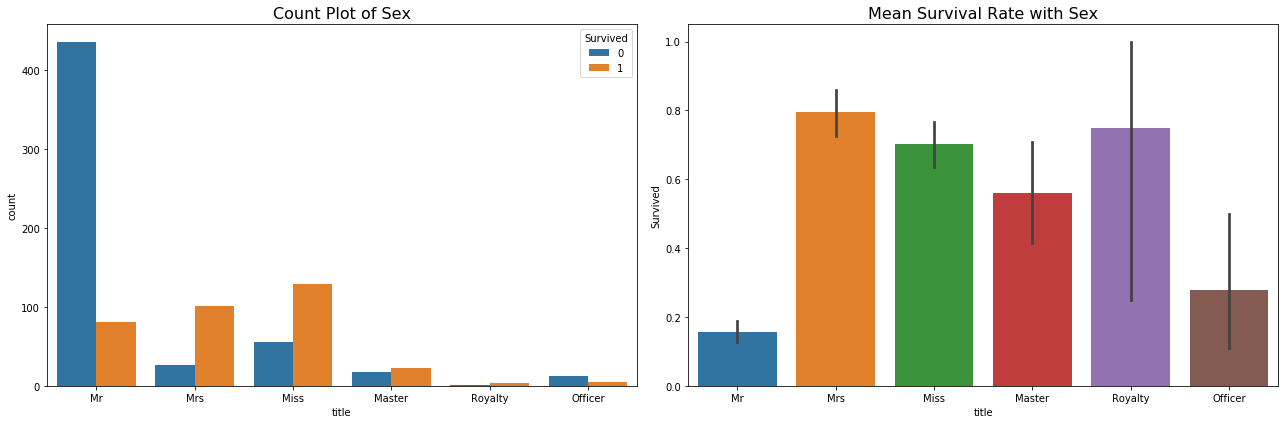

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'title', hue='Survived', data = df, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize = 16)
sns.barplot(x='title', y='Survived', data = df, ax=ax[1])
ax[1].set_title('Mean Survival Rate with Sex',fontsize = 16)
plt.tight_layout()
plt.show()

<h3>Create a function to clean the data</h3>

In [37]:
def clean_data(df):
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
    df_Cabin = df[~pd.isnull(df['Cabin'])].reset_index()
    def get_letter(x):
        import re
        pattern = r'^[a-zA-Z]'
        return re.search(pattern,x).group(0).strip()
    df_Cabin = df[~pd.isnull(df['Cabin'])].reset_index()
    Cabin_class = []
    for i in range(len(df_Cabin)):
        x = df_Cabin['Cabin'].iloc[i]
        Cabin_class.append(get_letter(x))
    df_Cabin['Cabin_class'] = Cabin_class
    df['Cabin'].fillna('M', inplace = True)
    Cabin_class = []
    for i in range(len(df)):
        x = df['Cabin'].iloc[i]
        Cabin_class.append(get_letter(x))
    df['Cabin_class'] = Cabin_class
    df['Cabin_class'] = df['Cabin_class'].replace(['A', 'B', 'C'], 'ABC')
    df['Cabin_class'] = df['Cabin_class'].replace(['D', 'E'], 'DE')
    df['Cabin_class'] = df['Cabin_class'].replace(['F', 'G', 'T'], 'FGT')
    family = []
    for i in range(len(df)):
        family.append(df['SibSp'][i] + df['Parch'][i] + 1)
    df['family_size'] = family
    title = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['title'] = title
    Title_Dictionary = {
        "Capt": "Officer",
        "Col": "Officer",
        "Major": "Officer",
        "Jonkheer": "Master",
        "Don": "Royalty",
        "Sir" : "Royalty",
        "Dr": "Officer",
        "Rev": "Officer",
        "the Countess":"Royalty",
        "Mme": "Mrs",
        "Mlle": "Miss",
        "Ms": "Mrs",
        "Mr" : "Mr",
        "Mrs" : "Mrs",
        "Miss" : "Miss",
        "Master" : "Master",
        "Lady" : "Royalty",
        "Dona" : "Royalty"    
    }
    df['title'] = df['title'].map(Title_Dictionary)
    return df
    
    
    

In [38]:
df = pd.read_csv('train.csv')
df = clean_data(df)

In [39]:
df_test = clean_data(df_test)

In [40]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_class,family_size,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,M,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,ABC,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,M,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,ABC,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,M,1,Mr


<h3>Random Forest model</h3>

In [41]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/boris/anaconda3/envs/python/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/l7/sntlh66s6ps1y74qj2mr_t300000gn/T/tmpr8t51jrr
  JVM stdout: /var/folders/l7/sntlh66s6ps1y74qj2mr_t300000gn/T/tmpr8t51jrr/h2o_boris_started_from_python.out
  JVM stderr: /var/folders/l7/sntlh66s6ps1y74qj2mr_t300000gn/T/tmpr8t51jrr/h2o_boris_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_boris_q80y4e
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [42]:
h2o_df = H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
h2o_df['Survived'] = h2o_df['Survived'].asfactor()
h2o_df.summary()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_class,family_size,title
type,int,enum,int,string,enum,real,int,int,int,real,enum,enum,enum,int,enum
mins,1.0,,1.0,NaN,,0.42,0.0,0.0,693.0,0.0,,,,1.0,
mean,446.0,,2.3086419753086447,NaN,,29.112424242424225,0.5230078563411893,0.3815937149270483,260318.5491679275,32.20420796857465,,,,1.904601571268239,
maxs,891.0,,3.0,NaN,,80.0,8.0,6.0,3101298.0,512.3292,,,,11.0,
sigma,257.3538420152301,,0.8360712409770491,NaN,,13.304424074688168,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,,,,1.613458541355087,
zeros,0,,0,0,,0,608,678,0,15,,,,0,
missing,0,0,0,0,0,0,0,0,230,0,0,0,0,0,0
0,1.0,0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,nan,7.25,M,S,M,2.0,Mr
1,2.0,1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1.0,0.0,nan,71.2833,C85,C,ABC,2.0,Mrs
2,3.0,1,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,nan,7.925,M,S,M,1.0,Miss


In [44]:
strat_split = h2o_df['Survived'].stratified_split(test_frac=0.25, seed = 1)
train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']
#feature = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'family_size','Cabin_class', 'title']
feature = ['Pclass', 'Sex', 'Age', 'Fare', 'family_size', 'title']
target = 'Survived'

In [45]:
model = H2ORandomForestEstimator(balance_classes = True, ntrees = 50,
                                max_depth = 10, mtries = -1, seed = 1,
                                score_each_iteration = True)
model.train(x = feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


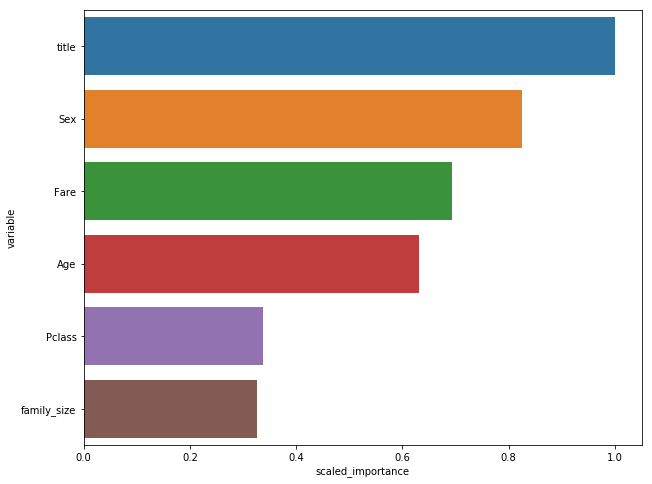

In [46]:
importance = model.varimp(use_pandas = True)
fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(x = 'scaled_importance', y='variable', data=importance)
plt.show()

In [47]:
importance

,variable,relative_importance,scaled_importance,percentage
0,title,1478.131958,1.000000,0.262346
1,Sex,1218.708984,0.824493,0.216302
2,Fare,1023.995544,0.692763,0.181743
3,Age,931.748230,0.630355,0.165371
4,Pclass,500.308716,0.338474,0.088797
5,family_size,481.400360,0.325682,0.085441


In [48]:
train_true = train.as_data_frame()['Survived'].values
test_true = test.as_data_frame()['Survived'].values

In [49]:
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [50]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [51]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.57).astype(int)))


              precision    recall  f1-score   support

           0       0.83      0.96      0.89       137
           1       0.91      0.70      0.79        86

    accuracy                           0.86       223
   macro avg       0.87      0.83      0.84       223
weighted avg       0.86      0.86      0.85       223



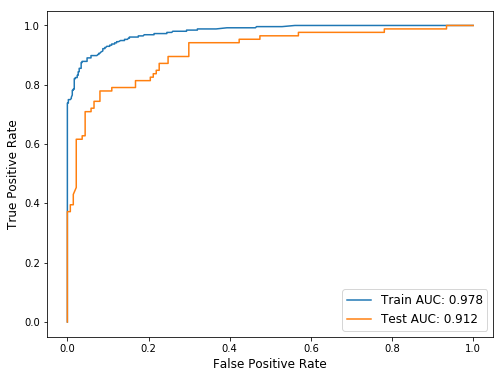

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_fpr, train_tpr, label = 'Train AUC: '+str(train_auc))
ax.plot(test_fpr, test_tpr, label = 'Test AUC: '+str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Positive Rate', fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

In [53]:
def prediction(df_test, model, cutoff = 0.5):
    h2o_df_test = H2OFrame(df_test)
    p = model.predict(h2o_df_test).as_data_frame()['p1'].values
    df_test['p'] = p
    Survived = []
    for i in range(len(df_test)):
        if df_test['p'][i] > cutoff:
            Survived.append(1)
        else:
            Survived.append(0)
    df_test['Survived'] = Survived
    submission = df_test[['PassengerId', 'Survived']]
    submission.to_csv('submission.csv', header = True, index = None)

In [54]:
h2o_df_test = H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


<h3>Boosting</h3>

In [55]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

In [56]:
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.7, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

In [57]:
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)

In [58]:
gbm_grid1.train(x=feature, y=target,
                training_frame=train,
                validation_frame=test,
                ntrees=100,
                seed=1)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [59]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)

In [60]:
best_gbm1 = gbm_gridperf1.models[0]

In [61]:
best_gbm_perf1 = best_gbm1.model_performance(test)

In [62]:
best_gbm_perf1.auc()

0.9156764556102529

In [63]:
train_pred = best_gbm1.predict(train).as_data_frame()['p1'].values
test_pred = best_gbm1.predict(test).as_data_frame()['p1'].values

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [64]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

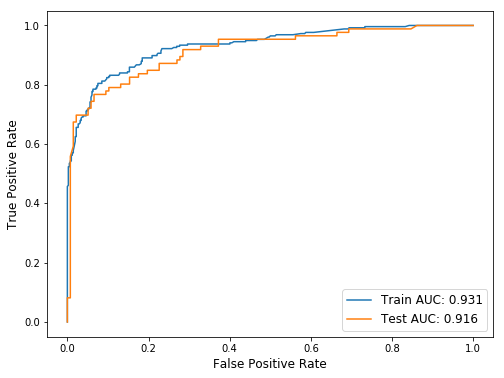

In [65]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_fpr, train_tpr, label = 'Train AUC: '+str(train_auc))
ax.plot(test_fpr, test_tpr, label = 'Test AUC: '+str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Positive Rate', fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

In [66]:
_

array([1.99169848, 0.99169848, 0.988135  , 0.98812801, 0.74661897,
       0.74303775, 0.69697049, 0.6589331 , 0.64865104, 0.57766194,
       0.57380322, 0.56894554, 0.54873446, 0.53694943, 0.51063556,
       0.47295164, 0.47023092, 0.46406877, 0.45744316, 0.42479597,
       0.40491096, 0.36886731, 0.3568274 , 0.34035469, 0.33802024,
       0.32012374, 0.31311408, 0.29154012, 0.2837294 , 0.26460669,
       0.24848157, 0.23142279, 0.23057037, 0.22610558, 0.21810087,
       0.21761872, 0.21158605, 0.21108547, 0.1983839 , 0.18458368,
       0.18266594, 0.16993522, 0.16471737, 0.15848675, 0.15553235,
       0.11260896, 0.11256883, 0.10187299, 0.09851747, 0.09560682,
       0.09548942, 0.09289017, 0.09244509, 0.09217867, 0.09045988,
       0.09010128, 0.08793869, 0.08764383, 0.08131281, 0.08086327,
       0.07951197, 0.0789177 , 0.07849068, 0.07087215, 0.06804183,
       0.00917267])

In [67]:
prediction(df_test, best_gbm1, 0.46406877)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [68]:
h2o.cluster().shutdown()

H2O session _sid_8135 closed.
